In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.preprocessing import OneHotEncoder

## Load the data

In [2]:
dia_data0=pd.read_csv('dataset_diabetes/diabetic_data.csv')
ids_map=pd.read_csv('dataset_diabetes/IDs_mapping.csv')

## Look at some of the data

Seems it is all categorical?

In [3]:
dia_data0.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
ids_map.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


## Check for number of unique values for each potential feature

In [5]:
potential_features=dia_data0.columns
for n in potential_features:
    num_uniq=len(dia_data0[n].unique())
    print('Number of unique '+ n + ': '+str(num_uniq))

Number of unique encounter_id: 101766
Number of unique patient_nbr: 71518
Number of unique race: 6
Number of unique gender: 3
Number of unique age: 10
Number of unique weight: 10
Number of unique admission_type_id: 8
Number of unique discharge_disposition_id: 26
Number of unique admission_source_id: 17
Number of unique time_in_hospital: 14
Number of unique payer_code: 18
Number of unique medical_specialty: 73
Number of unique num_lab_procedures: 118
Number of unique num_procedures: 7
Number of unique num_medications: 75
Number of unique number_outpatient: 39
Number of unique number_emergency: 33
Number of unique number_inpatient: 21
Number of unique diag_1: 717
Number of unique diag_2: 749
Number of unique diag_3: 790
Number of unique number_diagnoses: 16
Number of unique max_glu_serum: 4
Number of unique A1Cresult: 4
Number of unique metformin: 4
Number of unique repaglinide: 4
Number of unique nateglinide: 4
Number of unique chlorpropamide: 4
Number of unique glimepiride: 4
Number of

## Delete uninformative features

The 101,766 patient encounters all have the same value for 2 features:

'examide' and 'citoglipton'

These two features will not be useful so we can delete them. 

In [6]:
dia_data=dia_data0.drop(['examide','citoglipton'], axis=1)

In [7]:
for n in potential_features:
    num_uniq=len(dia_data0[n].unique())
    print('Number of unique '+ n + ': '+str(num_uniq))
    if num_uniq<40: # look at unique lists that aren't too long
        print(dia_data0[n].unique())

Number of unique encounter_id: 101766
Number of unique patient_nbr: 71518
Number of unique race: 6
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
Number of unique gender: 3
['Female' 'Male' 'Unknown/Invalid']
Number of unique age: 10
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Number of unique weight: 10
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
Number of unique admission_type_id: 8
[6 1 2 3 4 5 8 7]
Number of unique discharge_disposition_id: 26
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
Number of unique admission_source_id: 17
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
Number of unique time_in_hospital: 14
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
Number of unique payer_code: 18
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
Number of unique medical_specialty

## Prep data for conversion to binary data

Will use OneHotEncoder from sklearn.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

Potential features (X) will be all except identifiers 'encounter_id' and 'patient_nbr'.

In [8]:
X_df=dia_data.drop(['encounter_id', 'patient_nbr'], axis=1)

# Data visualization
## First convert the categorical data to binary data

The dataframe X_df will be converted into binary data by OneHotEncoder after I remove a variable I am curious about - this variable we will later label the data with and see if unsupervised learning - dimensionality reduction - separates the data by this selected category (even when it is not in the training data).

Conversion to binary is done within the function 'separation_check' with sklearn's OneHotEncoder.

## Define functions

In [9]:
uniq_colors=['cyan','teal','navy','darkviolet','hotpink','maroon','peru','gold','forestgreen','palegreen'] 
#https://matplotlib.org/stable/gallery/color/named_colors.html
def make_3_plots(pc1,pc2,pc3,labels): #makes plots of  comp 1v2, 1v3, and 2v3
    align_embed= pd.DataFrame({'pc1': pc1.values,'pc2': pc2.values,'pc3': pc3.values},index=labels)
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc1'],drug1['pc2'],c=uniq_colors[i],label=r,alpha=0.05)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc1'],drug1['pc3'],c=uniq_colors[i],label=r,alpha=0.05)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 3')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()
    fig, ax = plt.subplots(figsize=(8, 6)) #init  fig
    for i,r in enumerate(np.unique(align_embed.index.values)):
        drug1=align_embed[align_embed.index == r]
        ax.scatter(drug1['pc2'],drug1['pc3'],c=uniq_colors[i],label=r,alpha=0.05)
        ax.set_xlabel('PC 2')
        ax.set_ylabel('PC 3')
    ax.legend(loc="right",bbox_to_anchor=(1.6, 0.5)) #make legend not on the plot
    plt.show()

In [10]:
def separation_check(variable_of_interest): #input string
    X_df2=X_df.drop([variable_of_interest], axis=1)
    X_array=X_df2.to_numpy()
    binarydat=OneHotEncoder().fit_transform(X_array)
    svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
    compss = svd.fit_transform(binarydat)
    #make into dataframe if you want to view with labels
    componentDf = pd.DataFrame(data = compss, columns = ['SVD 1', 'SVD 2', 'SVD 3'])
    c1=componentDf['SVD 1'] #make into numpy arrays
    c2=componentDf['SVD 2']
    c3=componentDf['SVD 3']
    labels=dia_data0[variable_of_interest]
    make_3_plots(c1,c2,c3,labels)

## Test variable 'insulin'

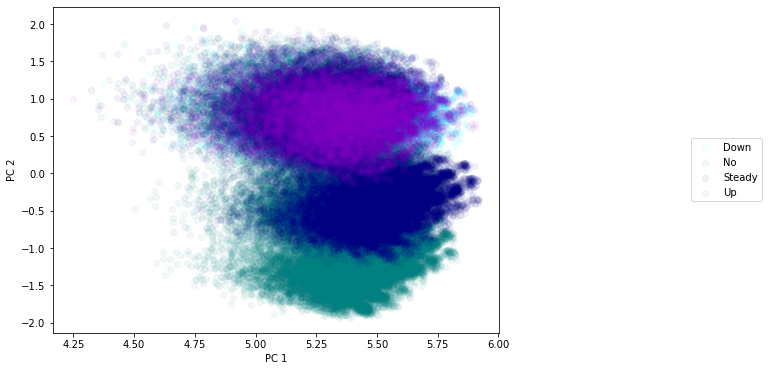

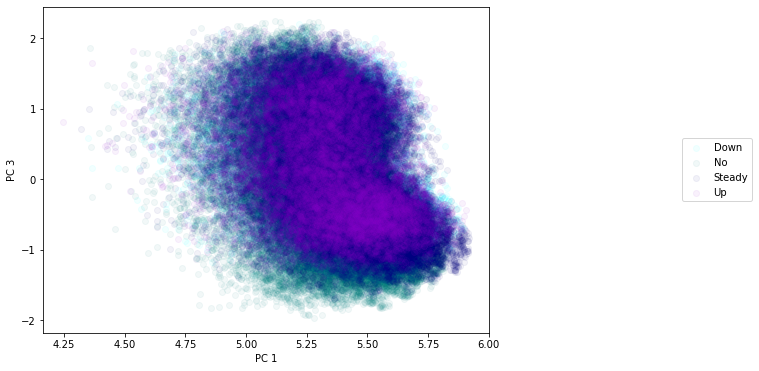

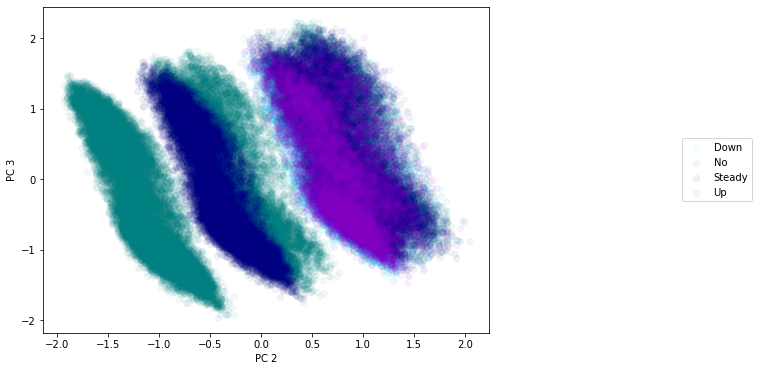

In [11]:
separation_check('insulin')

## Test variable 'change'

I assume this means change in condition?

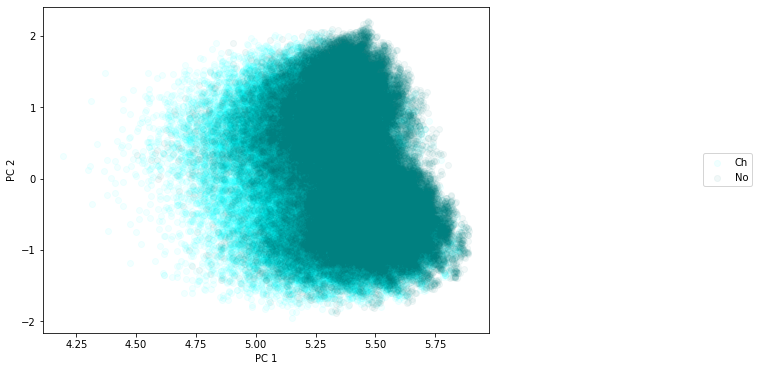

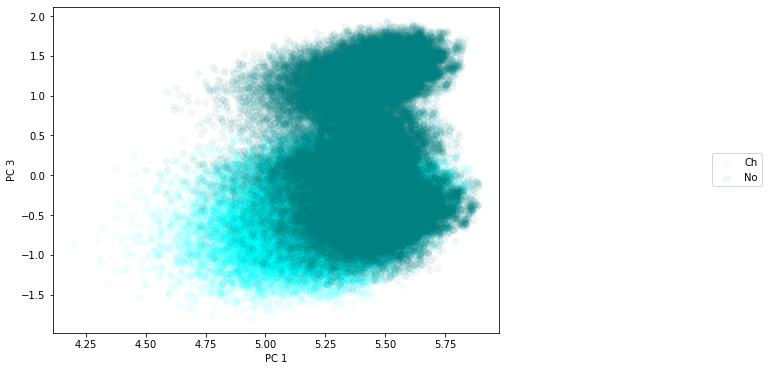

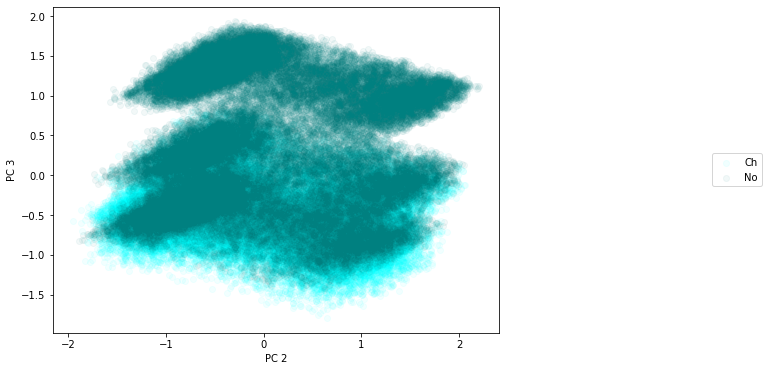

In [12]:
separation_check('change')

## Test variable 'age'

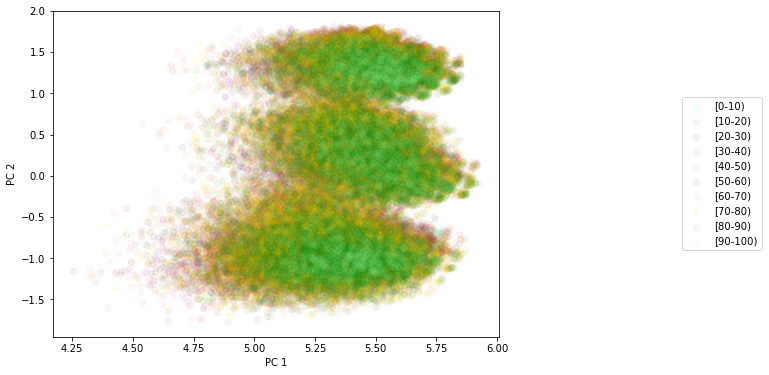

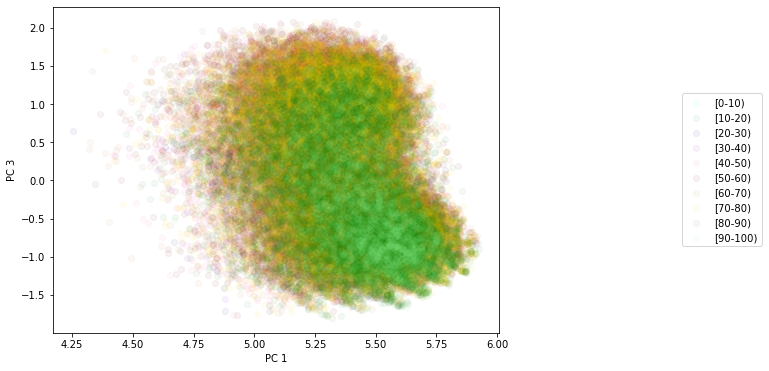

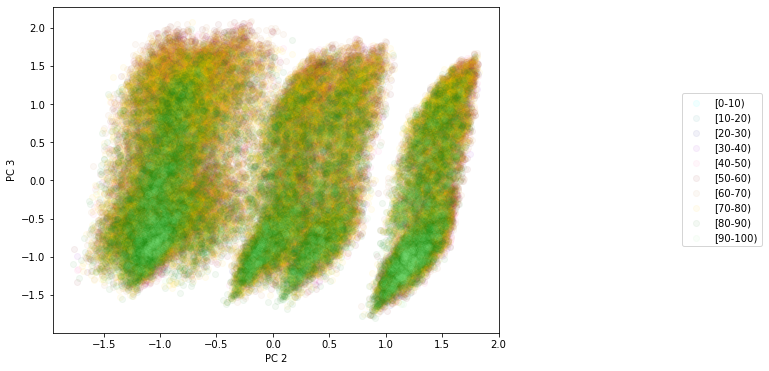

In [13]:
separation_check('age')